# LSTM - vanilla

In [1]:
best_model = "best_model17.pt"

## Load and prepare data

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


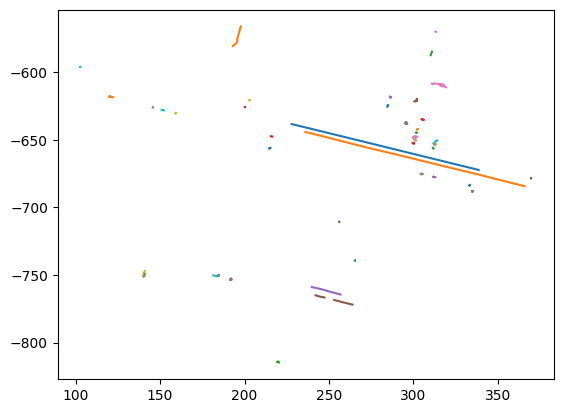

In [4]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [11]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, 2:4].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )
        
        # print(f'x: {data_item.x.shape}')
        # print(f'y: {data_item.y.shape}')

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [12]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [13]:
class AutoRegressiveLSTM(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=2, num_layers=1, future_steps=60):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.future_steps = future_steps

        # Encoder: takes in past trajectory
        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Decoder: predicts future positions one step at a time
        self.decoder = nn.LSTM(input_size=2, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim, output_dim)

    def forward(self, data, forcing_ratio = 0.5):
    # def forward(self, data):
        x = data.x[..., :5]  # Use position + velocity
        x = x.reshape(-1, 50, 50, 5)[:, 0, :, :]  # (batch, 50, 5), ego only
         
        batch_size = x.size(0)
        
        if self.training:
            future = data.y.view(batch_size, 60, 2) # (batch, 60, 2)

        # Encode past
        _, (hidden, cell) = self.encoder(x)

        # Initialize decoder input with last observed position
        decoder_input = x[:, -1, :2].unsqueeze(1)  # (batch, 1, 2)
        
        # print("decoder_input.shape - initial", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = []

        for t in range(self.future_steps):
            output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.out(output)  # (batch, 1, 2)
            outputs.append(pred)

            # TODO: remove forcing ratio?
            if self.training and random.random() < forcing_ratio:
            # if self.training:
                decoder_input = future[:, t].unsqueeze(1)  # ground truth
                # print("decoder_input.shape - teacher forcing", decoder_input.shape)  # should be (batch, 1, 2)
            else:
                decoder_input = pred.detach()  # predicted output as next input
                # print("decoder_input.shape - autoreg", decoder_input.shape)  # should be (batch, 1, 2)

        outputs = torch.cat(outputs, dim=1)  # (batch, 60, 2)
        return outputs

# Train

In [17]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        forcing_ratio = max(0.0, 1.0 - epoch / 50)
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch, forcing_ratio=forcing_ratio)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                # batch.scale turns scale from 7.0 or (1,) shape i.e. scalar to (B,) shape
                # batch.origin turns origin from (1,2) shape to (B,2)
                
                # then .view(-1, 1, 1) turns scale from (B,) to (B, 1, 1)
                # then .unsqueeze(1) turns origin from (B, 2) to (B, 1, 2)
                # because pred and y have shapes (B, 60, 2) so these transformations make them compatible for the calculation
                
                # TODO: should scale?
                pred_unnorm = pred * batch.scale.view(-1, 1, 1)
                y_unnorm = y * batch.scale.view(-1, 1, 1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE (normalized) {val_loss:.4f} | "
            f"Val MAE (true) {val_mae:.4f} | Val MSE (true) {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [22]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = AutoRegressiveLSTM()
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007,  # => 8.98, ps: 10.01
        lr=0.005,  # Lower learning rate
        patience=20,  # More patience
        epochs=100
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1)
            y = y * batch.scale.view(-1, 1, 1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [23]:
train_and_evaluate_model()

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_65163/1407810273.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   1%|          | 1/100 [00:18<30:46, 18.65s/epoch]

Epoch 000 | LR 0.004750 | Train MSE 0.0733 | Val MSE (normalized) 0.1832 | Val MAE (true) 1.9559 | Val MSE (true) 8.9752
Sample pred first 3 steps: [[-0.00250187  0.00629158]
 [-0.00646605  0.00709098]
 [-0.01011325  0.00488186]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: inf -> 0.183168


Epoch:   2%|▏         | 2/100 [00:37<30:53, 18.91s/epoch]

Epoch 001 | LR 0.004513 | Train MSE 0.0041 | Val MSE (normalized) 0.2902 | Val MAE (true) 2.2948 | Val MSE (true) 14.2185


Epoch:   3%|▎         | 3/100 [00:55<29:51, 18.47s/epoch]

Epoch 002 | LR 0.004287 | Train MSE 0.0041 | Val MSE (normalized) 0.2266 | Val MAE (true) 2.2309 | Val MSE (true) 11.1054


Epoch:   4%|▍         | 4/100 [01:13<28:57, 18.10s/epoch]

Epoch 003 | LR 0.004073 | Train MSE 0.0041 | Val MSE (normalized) 0.2033 | Val MAE (true) 2.0413 | Val MSE (true) 9.9614


Epoch:   5%|▌         | 5/100 [01:31<28:38, 18.09s/epoch]

Epoch 004 | LR 0.003869 | Train MSE 0.0040 | Val MSE (normalized) 0.2513 | Val MAE (true) 2.1226 | Val MSE (true) 12.3160


Epoch:   6%|▌         | 6/100 [01:49<28:31, 18.20s/epoch]

Epoch 005 | LR 0.003675 | Train MSE 0.0040 | Val MSE (normalized) 0.1468 | Val MAE (true) 1.7137 | Val MSE (true) 7.1938
Sample pred first 3 steps: [[0.00486299 0.00516352]
 [0.00569075 0.00657455]
 [0.00704802 0.01084721]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.183168 -> 0.146812


Epoch:   7%|▋         | 7/100 [02:07<27:54, 18.00s/epoch]

Epoch 006 | LR 0.003492 | Train MSE 0.0040 | Val MSE (normalized) 0.1928 | Val MAE (true) 2.1384 | Val MSE (true) 9.4462


Epoch:   8%|▊         | 8/100 [02:25<27:30, 17.94s/epoch]

Epoch 007 | LR 0.003317 | Train MSE 0.0040 | Val MSE (normalized) 0.2088 | Val MAE (true) 2.1447 | Val MSE (true) 10.2336


Epoch:   9%|▉         | 9/100 [02:42<27:03, 17.84s/epoch]

Epoch 008 | LR 0.003151 | Train MSE 0.0041 | Val MSE (normalized) 0.2563 | Val MAE (true) 2.0420 | Val MSE (true) 12.5606


Epoch:  10%|█         | 10/100 [03:00<26:50, 17.90s/epoch]

Epoch 009 | LR 0.002994 | Train MSE 0.0040 | Val MSE (normalized) 0.1458 | Val MAE (true) 1.7850 | Val MSE (true) 7.1422
Validation improved: 0.146812 -> 0.145760


Epoch:  11%|█         | 11/100 [03:18<26:33, 17.91s/epoch]

Epoch 010 | LR 0.002844 | Train MSE 0.0040 | Val MSE (normalized) 0.2248 | Val MAE (true) 2.2846 | Val MSE (true) 11.0152
Sample pred first 3 steps: [[-0.04332814  0.02221978]
 [-0.04396889  0.03311067]
 [-0.0449826   0.0407254 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  12%|█▏        | 12/100 [03:36<26:14, 17.89s/epoch]

Epoch 011 | LR 0.002702 | Train MSE 0.0039 | Val MSE (normalized) 0.2943 | Val MAE (true) 2.9525 | Val MSE (true) 14.4212


Epoch:  13%|█▎        | 13/100 [03:55<26:12, 18.08s/epoch]

Epoch 012 | LR 0.002567 | Train MSE 0.0038 | Val MSE (normalized) 0.3959 | Val MAE (true) 2.6539 | Val MSE (true) 19.4005


Epoch:  14%|█▍        | 14/100 [04:12<25:42, 17.94s/epoch]

Epoch 013 | LR 0.002438 | Train MSE 0.0032 | Val MSE (normalized) 0.4253 | Val MAE (true) 3.0035 | Val MSE (true) 20.8382


Epoch:  15%|█▌        | 15/100 [04:30<25:11, 17.78s/epoch]

Epoch 014 | LR 0.002316 | Train MSE 0.0025 | Val MSE (normalized) 0.2342 | Val MAE (true) 2.3547 | Val MSE (true) 11.4744


Epoch:  16%|█▌        | 16/100 [04:48<25:12, 18.00s/epoch]

Epoch 015 | LR 0.002201 | Train MSE 0.0024 | Val MSE (normalized) 0.3617 | Val MAE (true) 3.0249 | Val MSE (true) 17.7239
Sample pred first 3 steps: [[-0.01136799  0.01510854]
 [-0.00347493  0.02215793]
 [ 0.00333438  0.03228718]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  17%|█▋        | 17/100 [05:07<25:15, 18.26s/epoch]

Epoch 016 | LR 0.002091 | Train MSE 0.0022 | Val MSE (normalized) 0.2751 | Val MAE (true) 2.6290 | Val MSE (true) 13.4793


Epoch:  18%|█▊        | 18/100 [05:25<24:41, 18.07s/epoch]

Epoch 017 | LR 0.001986 | Train MSE 0.0022 | Val MSE (normalized) 0.9897 | Val MAE (true) 4.6872 | Val MSE (true) 48.4967


Epoch:  19%|█▉        | 19/100 [05:43<24:26, 18.11s/epoch]

Epoch 018 | LR 0.001887 | Train MSE 0.0021 | Val MSE (normalized) 0.6752 | Val MAE (true) 4.1082 | Val MSE (true) 33.0855


Epoch:  20%|██        | 20/100 [06:01<24:06, 18.08s/epoch]

Epoch 019 | LR 0.001792 | Train MSE 0.0021 | Val MSE (normalized) 0.2735 | Val MAE (true) 2.7581 | Val MSE (true) 13.4009


Epoch:  21%|██        | 21/100 [06:18<23:38, 17.95s/epoch]

Epoch 020 | LR 0.001703 | Train MSE 0.0020 | Val MSE (normalized) 0.1451 | Val MAE (true) 1.9004 | Val MSE (true) 7.1078
Sample pred first 3 steps: [[0.00418223 0.00401626]
 [0.01422232 0.01148359]
 [0.02159123 0.01736327]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.145760 -> 0.145057


Epoch:  22%|██▏       | 22/100 [06:36<23:16, 17.90s/epoch]

Epoch 021 | LR 0.001618 | Train MSE 0.0021 | Val MSE (normalized) 0.2513 | Val MAE (true) 2.5889 | Val MSE (true) 12.3143


Epoch:  23%|██▎       | 23/100 [06:52<22:06, 17.23s/epoch]

Epoch 022 | LR 0.001537 | Train MSE 0.0021 | Val MSE (normalized) 0.4313 | Val MAE (true) 3.2954 | Val MSE (true) 21.1337


Epoch:  24%|██▍       | 24/100 [07:08<21:20, 16.85s/epoch]

Epoch 023 | LR 0.001460 | Train MSE 0.0022 | Val MSE (normalized) 0.5477 | Val MAE (true) 3.6831 | Val MSE (true) 26.8361


Epoch:  25%|██▌       | 25/100 [07:23<20:29, 16.40s/epoch]

Epoch 024 | LR 0.001387 | Train MSE 0.0020 | Val MSE (normalized) 0.2648 | Val MAE (true) 2.5420 | Val MSE (true) 12.9759


Epoch:  26%|██▌       | 26/100 [07:38<19:45, 16.02s/epoch]

Epoch 025 | LR 0.001318 | Train MSE 0.0022 | Val MSE (normalized) 0.1810 | Val MAE (true) 1.9444 | Val MSE (true) 8.8696
Sample pred first 3 steps: [[ 0.01370006 -0.00959174]
 [ 0.0159067  -0.01146152]
 [ 0.01517471 -0.01459973]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  27%|██▋       | 27/100 [07:55<19:34, 16.09s/epoch]

Epoch 026 | LR 0.001252 | Train MSE 0.0020 | Val MSE (normalized) 0.2087 | Val MAE (true) 2.0290 | Val MSE (true) 10.2281


Epoch:  28%|██▊       | 28/100 [08:10<19:03, 15.88s/epoch]

Epoch 027 | LR 0.001189 | Train MSE 0.0021 | Val MSE (normalized) 0.3359 | Val MAE (true) 3.0547 | Val MSE (true) 16.4595


Epoch:  29%|██▉       | 29/100 [08:26<18:44, 15.83s/epoch]

Epoch 028 | LR 0.001130 | Train MSE 0.0023 | Val MSE (normalized) 0.3735 | Val MAE (true) 3.0390 | Val MSE (true) 18.3025


Epoch:  30%|███       | 30/100 [08:41<18:19, 15.70s/epoch]

Epoch 029 | LR 0.001073 | Train MSE 0.0024 | Val MSE (normalized) 0.1298 | Val MAE (true) 1.7311 | Val MSE (true) 6.3578
Validation improved: 0.145057 -> 0.129751


Epoch:  31%|███       | 31/100 [08:57<18:08, 15.77s/epoch]

Epoch 030 | LR 0.001020 | Train MSE 0.0022 | Val MSE (normalized) 0.1566 | Val MAE (true) 1.9433 | Val MSE (true) 7.6749
Sample pred first 3 steps: [[-0.00734077  0.00425633]
 [-0.01265499  0.00459439]
 [-0.01905725  0.00257258]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  32%|███▏      | 32/100 [09:14<18:08, 16.00s/epoch]

Epoch 031 | LR 0.000969 | Train MSE 0.0024 | Val MSE (normalized) 0.2530 | Val MAE (true) 2.5460 | Val MSE (true) 12.3981


Epoch:  33%|███▎      | 33/100 [09:30<17:57, 16.09s/epoch]

Epoch 032 | LR 0.000920 | Train MSE 0.0022 | Val MSE (normalized) 0.2379 | Val MAE (true) 2.4157 | Val MSE (true) 11.6586


Epoch:  34%|███▍      | 34/100 [09:48<18:31, 16.84s/epoch]

Epoch 033 | LR 0.000874 | Train MSE 0.0025 | Val MSE (normalized) 0.1033 | Val MAE (true) 1.5535 | Val MSE (true) 5.0632
Validation improved: 0.129751 -> 0.103330


Epoch:  35%|███▌      | 35/100 [10:06<18:28, 17.06s/epoch]

Epoch 034 | LR 0.000830 | Train MSE 0.0026 | Val MSE (normalized) 0.3392 | Val MAE (true) 2.5461 | Val MSE (true) 16.6219


Epoch:  36%|███▌      | 36/100 [10:24<18:34, 17.41s/epoch]

Epoch 035 | LR 0.000789 | Train MSE 0.0029 | Val MSE (normalized) 0.1411 | Val MAE (true) 1.5879 | Val MSE (true) 6.9143
Sample pred first 3 steps: [[-0.00931422 -0.00638695]
 [-0.01154817 -0.00554347]
 [-0.01401402 -0.00565545]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  37%|███▋      | 37/100 [10:43<18:34, 17.68s/epoch]

Epoch 036 | LR 0.000749 | Train MSE 0.0026 | Val MSE (normalized) 0.2146 | Val MAE (true) 2.2684 | Val MSE (true) 10.5144


Epoch:  38%|███▊      | 38/100 [11:00<18:13, 17.64s/epoch]

Epoch 037 | LR 0.000712 | Train MSE 0.0027 | Val MSE (normalized) 0.1789 | Val MAE (true) 1.9949 | Val MSE (true) 8.7678


Epoch:  39%|███▉      | 39/100 [11:19<18:18, 18.01s/epoch]

Epoch 038 | LR 0.000676 | Train MSE 0.0033 | Val MSE (normalized) 0.0778 | Val MAE (true) 1.1835 | Val MSE (true) 3.8132
Validation improved: 0.103330 -> 0.077821


Epoch:  40%|████      | 40/100 [11:37<18:09, 18.15s/epoch]

Epoch 039 | LR 0.000643 | Train MSE 0.0047 | Val MSE (normalized) 0.0822 | Val MAE (true) 1.3070 | Val MSE (true) 4.0299


Epoch:  41%|████      | 41/100 [11:56<17:53, 18.20s/epoch]

Epoch 040 | LR 0.000610 | Train MSE 0.0044 | Val MSE (normalized) 0.0832 | Val MAE (true) 1.2682 | Val MSE (true) 4.0775
Sample pred first 3 steps: [[ 0.01087951 -0.00344244]
 [ 0.01246168 -0.00819182]
 [ 0.01384971 -0.01135163]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  42%|████▏     | 42/100 [12:14<17:30, 18.10s/epoch]

Epoch 041 | LR 0.000580 | Train MSE 0.0058 | Val MSE (normalized) 0.0563 | Val MAE (true) 1.0353 | Val MSE (true) 2.7579
Validation improved: 0.077821 -> 0.056283


Epoch:  43%|████▎     | 43/100 [12:31<17:01, 17.92s/epoch]

Epoch 042 | LR 0.000551 | Train MSE 0.0045 | Val MSE (normalized) 0.0522 | Val MAE (true) 0.8992 | Val MSE (true) 2.5583
Validation improved: 0.056283 -> 0.052211


Epoch:  44%|████▍     | 44/100 [12:49<16:47, 17.98s/epoch]

Epoch 043 | LR 0.000523 | Train MSE 0.0066 | Val MSE (normalized) 0.0765 | Val MAE (true) 1.1799 | Val MSE (true) 3.7480


Epoch:  45%|████▌     | 45/100 [13:07<16:30, 18.01s/epoch]

Epoch 044 | LR 0.000497 | Train MSE 0.0098 | Val MSE (normalized) 0.0493 | Val MAE (true) 0.9535 | Val MSE (true) 2.4143
Validation improved: 0.052211 -> 0.049271


Epoch:  46%|████▌     | 46/100 [13:26<16:16, 18.08s/epoch]

Epoch 045 | LR 0.000472 | Train MSE 0.0126 | Val MSE (normalized) 0.0505 | Val MAE (true) 0.9187 | Val MSE (true) 2.4742
Sample pred first 3 steps: [[ 0.00222878 -0.00092133]
 [ 0.00328842  0.00017224]
 [ 0.00355556  0.0015421 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  47%|████▋     | 47/100 [13:44<16:00, 18.13s/epoch]

Epoch 046 | LR 0.000449 | Train MSE 0.0145 | Val MSE (normalized) 0.1292 | Val MAE (true) 1.7005 | Val MSE (true) 6.3310


Epoch:  48%|████▊     | 48/100 [14:02<15:38, 18.05s/epoch]

Epoch 047 | LR 0.000426 | Train MSE 0.0235 | Val MSE (normalized) 0.0964 | Val MAE (true) 1.4613 | Val MSE (true) 4.7213


Epoch:  49%|████▉     | 49/100 [14:19<15:15, 17.95s/epoch]

Epoch 048 | LR 0.000405 | Train MSE 0.0297 | Val MSE (normalized) 0.0575 | Val MAE (true) 1.0320 | Val MSE (true) 2.8151


Epoch:  50%|█████     | 50/100 [14:37<14:56, 17.94s/epoch]

Epoch 049 | LR 0.000385 | Train MSE 0.0449 | Val MSE (normalized) 0.0554 | Val MAE (true) 1.0537 | Val MSE (true) 2.7169


Epoch:  51%|█████     | 51/100 [14:55<14:40, 17.97s/epoch]

Epoch 050 | LR 0.000365 | Train MSE 0.0579 | Val MSE (normalized) 0.0547 | Val MAE (true) 0.9650 | Val MSE (true) 2.6805
Sample pred first 3 steps: [[-0.01693688  0.00399284]
 [-0.01686993  0.00316997]
 [-0.01709246  0.00357944]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  52%|█████▏    | 52/100 [15:13<14:20, 17.92s/epoch]

Epoch 051 | LR 0.000347 | Train MSE 0.0575 | Val MSE (normalized) 0.0550 | Val MAE (true) 1.0684 | Val MSE (true) 2.6965


Epoch:  53%|█████▎    | 53/100 [15:32<14:14, 18.18s/epoch]

Epoch 052 | LR 0.000330 | Train MSE 0.0517 | Val MSE (normalized) 0.0452 | Val MAE (true) 0.8871 | Val MSE (true) 2.2152
Validation improved: 0.049271 -> 0.045209


Epoch:  54%|█████▍    | 54/100 [15:50<13:59, 18.24s/epoch]

Epoch 053 | LR 0.000313 | Train MSE 0.0486 | Val MSE (normalized) 0.0443 | Val MAE (true) 0.8844 | Val MSE (true) 2.1695
Validation improved: 0.045209 -> 0.044276


Epoch:  55%|█████▌    | 55/100 [16:09<13:49, 18.44s/epoch]

Epoch 054 | LR 0.000298 | Train MSE 0.0474 | Val MSE (normalized) 0.0457 | Val MAE (true) 0.9141 | Val MSE (true) 2.2391


Epoch:  56%|█████▌    | 56/100 [16:30<13:59, 19.09s/epoch]

Epoch 055 | LR 0.000283 | Train MSE 0.0460 | Val MSE (normalized) 0.0423 | Val MAE (true) 0.8007 | Val MSE (true) 2.0726
Sample pred first 3 steps: [[ 0.00228336 -0.00320976]
 [-0.00082117 -0.00719547]
 [-0.00381678 -0.00883772]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.044276 -> 0.042299


Epoch:  57%|█████▋    | 57/100 [16:48<13:30, 18.85s/epoch]

Epoch 056 | LR 0.000269 | Train MSE 0.0455 | Val MSE (normalized) 0.0470 | Val MAE (true) 0.9355 | Val MSE (true) 2.3015


Epoch:  58%|█████▊    | 58/100 [17:12<14:13, 20.33s/epoch]

Epoch 057 | LR 0.000255 | Train MSE 0.0451 | Val MSE (normalized) 0.0454 | Val MAE (true) 0.9321 | Val MSE (true) 2.2246


Epoch:  59%|█████▉    | 59/100 [17:38<15:05, 22.08s/epoch]

Epoch 058 | LR 0.000242 | Train MSE 0.0447 | Val MSE (normalized) 0.0409 | Val MAE (true) 0.7921 | Val MSE (true) 2.0058
Validation improved: 0.042299 -> 0.040934


Epoch:  60%|██████    | 60/100 [18:05<15:35, 23.38s/epoch]

Epoch 059 | LR 0.000230 | Train MSE 0.0440 | Val MSE (normalized) 0.0430 | Val MAE (true) 0.8762 | Val MSE (true) 2.1052


Epoch:  61%|██████    | 61/100 [18:31<15:50, 24.36s/epoch]

Epoch 060 | LR 0.000219 | Train MSE 0.0453 | Val MSE (normalized) 0.0403 | Val MAE (true) 0.7842 | Val MSE (true) 1.9767
Sample pred first 3 steps: [[-0.00675096 -0.00110286]
 [-0.00563928  0.00166589]
 [-0.00565489  0.00333773]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.040934 -> 0.040340


Epoch:  62%|██████▏   | 62/100 [18:52<14:43, 23.24s/epoch]

Epoch 061 | LR 0.000208 | Train MSE 0.0430 | Val MSE (normalized) 0.0397 | Val MAE (true) 0.7644 | Val MSE (true) 1.9474
Validation improved: 0.040340 -> 0.039743


Epoch:  63%|██████▎   | 63/100 [19:11<13:39, 22.15s/epoch]

Epoch 062 | LR 0.000197 | Train MSE 0.0432 | Val MSE (normalized) 0.0397 | Val MAE (true) 0.7713 | Val MSE (true) 1.9433
Validation improved: 0.039743 -> 0.039660


Epoch:  64%|██████▍   | 64/100 [19:31<12:51, 21.44s/epoch]

Epoch 063 | LR 0.000188 | Train MSE 0.0420 | Val MSE (normalized) 0.0416 | Val MAE (true) 0.8406 | Val MSE (true) 2.0361


Epoch:  65%|██████▌   | 65/100 [19:51<12:13, 20.97s/epoch]

Epoch 064 | LR 0.000178 | Train MSE 0.0425 | Val MSE (normalized) 0.0420 | Val MAE (true) 0.8293 | Val MSE (true) 2.0573


Epoch:  66%|██████▌   | 66/100 [20:11<11:38, 20.54s/epoch]

Epoch 065 | LR 0.000169 | Train MSE 0.0417 | Val MSE (normalized) 0.0409 | Val MAE (true) 0.8079 | Val MSE (true) 2.0045
Sample pred first 3 steps: [[-0.00782386 -0.00971637]
 [-0.00563586 -0.00629577]
 [-0.00693406 -0.00214622]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  67%|██████▋   | 67/100 [20:30<11:11, 20.35s/epoch]

Epoch 066 | LR 0.000161 | Train MSE 0.0416 | Val MSE (normalized) 0.0466 | Val MAE (true) 0.9515 | Val MSE (true) 2.2849


Epoch:  68%|██████▊   | 68/100 [20:50<10:44, 20.14s/epoch]

Epoch 067 | LR 0.000153 | Train MSE 0.0414 | Val MSE (normalized) 0.0396 | Val MAE (true) 0.7871 | Val MSE (true) 1.9392
Validation improved: 0.039660 -> 0.039575


Epoch:  69%|██████▉   | 69/100 [21:10<10:17, 19.93s/epoch]

Epoch 068 | LR 0.000145 | Train MSE 0.0409 | Val MSE (normalized) 0.0403 | Val MAE (true) 0.8048 | Val MSE (true) 1.9768


Epoch:  70%|███████   | 70/100 [21:29<09:53, 19.79s/epoch]

Epoch 069 | LR 0.000138 | Train MSE 0.0411 | Val MSE (normalized) 0.0387 | Val MAE (true) 0.7532 | Val MSE (true) 1.8966
Validation improved: 0.039575 -> 0.038706


Epoch:  71%|███████   | 71/100 [21:45<09:03, 18.76s/epoch]

Epoch 070 | LR 0.000131 | Train MSE 0.0414 | Val MSE (normalized) 0.0425 | Val MAE (true) 0.8694 | Val MSE (true) 2.0821
Sample pred first 3 steps: [[ 0.01863012  0.00514652]
 [ 0.01884721  0.00166727]
 [ 0.01278753 -0.00080672]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  72%|███████▏  | 72/100 [22:02<08:23, 17.99s/epoch]

Epoch 071 | LR 0.000124 | Train MSE 0.0404 | Val MSE (normalized) 0.0382 | Val MAE (true) 0.7507 | Val MSE (true) 1.8722
Validation improved: 0.038706 -> 0.038208


Epoch:  73%|███████▎  | 73/100 [22:18<07:54, 17.57s/epoch]

Epoch 072 | LR 0.000118 | Train MSE 0.0405 | Val MSE (normalized) 0.0378 | Val MAE (true) 0.7524 | Val MSE (true) 1.8520
Validation improved: 0.038208 -> 0.037795


Epoch:  74%|███████▍  | 74/100 [22:36<07:38, 17.62s/epoch]

Epoch 073 | LR 0.000112 | Train MSE 0.0404 | Val MSE (normalized) 0.0384 | Val MAE (true) 0.7648 | Val MSE (true) 1.8824


Epoch:  75%|███████▌  | 75/100 [22:54<07:25, 17.84s/epoch]

Epoch 074 | LR 0.000107 | Train MSE 0.0405 | Val MSE (normalized) 0.0394 | Val MAE (true) 0.8088 | Val MSE (true) 1.9284


Epoch:  76%|███████▌  | 76/100 [23:18<07:53, 19.73s/epoch]

Epoch 075 | LR 0.000101 | Train MSE 0.0402 | Val MSE (normalized) 0.0377 | Val MAE (true) 0.7345 | Val MSE (true) 1.8463
Sample pred first 3 steps: [[-0.00085688 -0.00124783]
 [ 0.00323849 -0.0018606 ]
 [ 0.00301398 -0.00167248]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.037795 -> 0.037679


Epoch:  77%|███████▋  | 77/100 [23:42<08:02, 20.96s/epoch]

Epoch 076 | LR 0.000096 | Train MSE 0.0397 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7281 | Val MSE (true) 1.8166
Validation improved: 0.037679 -> 0.037073


Epoch:  78%|███████▊  | 78/100 [24:07<08:07, 22.14s/epoch]

Epoch 077 | LR 0.000091 | Train MSE 0.0401 | Val MSE (normalized) 0.0383 | Val MAE (true) 0.7603 | Val MSE (true) 1.8784


Epoch:  79%|███████▉  | 79/100 [24:31<07:52, 22.51s/epoch]

Epoch 078 | LR 0.000087 | Train MSE 0.0398 | Val MSE (normalized) 0.0376 | Val MAE (true) 0.7420 | Val MSE (true) 1.8438


Epoch:  80%|████████  | 80/100 [24:55<07:44, 23.23s/epoch]

Epoch 079 | LR 0.000083 | Train MSE 0.0395 | Val MSE (normalized) 0.0379 | Val MAE (true) 0.7477 | Val MSE (true) 1.8573


Epoch:  81%|████████  | 81/100 [25:19<07:23, 23.36s/epoch]

Epoch 080 | LR 0.000078 | Train MSE 0.0394 | Val MSE (normalized) 0.0383 | Val MAE (true) 0.7358 | Val MSE (true) 1.8772
Sample pred first 3 steps: [[ 0.00118152  0.00134895]
 [ 0.00251173 -0.00089694]
 [ 0.00136239 -0.00288486]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  82%|████████▏ | 82/100 [25:47<07:26, 24.81s/epoch]

Epoch 081 | LR 0.000075 | Train MSE 0.0395 | Val MSE (normalized) 0.0380 | Val MAE (true) 0.7621 | Val MSE (true) 1.8631


Epoch:  83%|████████▎ | 83/100 [26:19<07:37, 26.93s/epoch]

Epoch 082 | LR 0.000071 | Train MSE 0.0391 | Val MSE (normalized) 0.0376 | Val MAE (true) 0.7269 | Val MSE (true) 1.8412


Epoch:  84%|████████▍ | 84/100 [26:53<07:42, 28.88s/epoch]

Epoch 083 | LR 0.000067 | Train MSE 0.0393 | Val MSE (normalized) 0.0382 | Val MAE (true) 0.7564 | Val MSE (true) 1.8711


Epoch:  85%|████████▌ | 85/100 [27:24<07:24, 29.65s/epoch]

Epoch 084 | LR 0.000064 | Train MSE 0.0390 | Val MSE (normalized) 0.0383 | Val MAE (true) 0.7521 | Val MSE (true) 1.8767


Epoch:  86%|████████▌ | 86/100 [27:56<07:06, 30.48s/epoch]

Epoch 085 | LR 0.000061 | Train MSE 0.0392 | Val MSE (normalized) 0.0378 | Val MAE (true) 0.7741 | Val MSE (true) 1.8528
Sample pred first 3 steps: [[-0.00671277  0.00404021]
 [-0.00276163  0.00151126]
 [-0.00160619 -0.00071052]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  87%|████████▋ | 87/100 [28:26<06:33, 30.24s/epoch]

Epoch 086 | LR 0.000058 | Train MSE 0.0388 | Val MSE (normalized) 0.0380 | Val MAE (true) 0.7605 | Val MSE (true) 1.8612


Epoch:  88%|████████▊ | 88/100 [28:59<06:11, 30.99s/epoch]

Epoch 087 | LR 0.000055 | Train MSE 0.0388 | Val MSE (normalized) 0.0373 | Val MAE (true) 0.7390 | Val MSE (true) 1.8256


Epoch:  89%|████████▉ | 89/100 [29:31<05:44, 31.33s/epoch]

Epoch 088 | LR 0.000052 | Train MSE 0.0386 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7399 | Val MSE (true) 1.8250


Epoch:  90%|█████████ | 90/100 [30:04<05:19, 31.98s/epoch]

Epoch 089 | LR 0.000049 | Train MSE 0.0388 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7322 | Val MSE (true) 1.7935
Validation improved: 0.037073 -> 0.036602


Epoch:  91%|█████████ | 91/100 [30:48<05:18, 35.38s/epoch]

Epoch 090 | LR 0.000047 | Train MSE 0.0384 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7289 | Val MSE (true) 1.8230
Sample pred first 3 steps: [[-0.00550228  0.00329245]
 [-0.00257915  0.00145865]
 [-0.00109871  0.0015935 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  92%|█████████▏| 92/100 [31:29<04:57, 37.18s/epoch]

Epoch 091 | LR 0.000045 | Train MSE 0.0387 | Val MSE (normalized) 0.0366 | Val MAE (true) 0.7199 | Val MSE (true) 1.7922
Validation improved: 0.036602 -> 0.036575


Epoch:  93%|█████████▎| 93/100 [32:03<04:12, 36.08s/epoch]

Epoch 092 | LR 0.000042 | Train MSE 0.0385 | Val MSE (normalized) 0.0376 | Val MAE (true) 0.7686 | Val MSE (true) 1.8419


Epoch:  94%|█████████▍| 94/100 [32:31<03:21, 33.62s/epoch]

Epoch 093 | LR 0.000040 | Train MSE 0.0384 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7289 | Val MSE (true) 1.7983


Epoch:  95%|█████████▌| 95/100 [32:58<02:38, 31.71s/epoch]

Epoch 094 | LR 0.000038 | Train MSE 0.0382 | Val MSE (normalized) 0.0367 | Val MAE (true) 0.7241 | Val MSE (true) 1.8000


Epoch:  96%|█████████▌| 96/100 [33:26<02:02, 30.55s/epoch]

Epoch 095 | LR 0.000036 | Train MSE 0.0383 | Val MSE (normalized) 0.0370 | Val MAE (true) 0.7405 | Val MSE (true) 1.8123
Sample pred first 3 steps: [[-0.00551293  0.00459098]
 [-0.00466138  0.00156906]
 [-0.00439693 -0.00077004]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  97%|█████████▋| 97/100 [33:54<01:29, 29.98s/epoch]

Epoch 096 | LR 0.000035 | Train MSE 0.0382 | Val MSE (normalized) 0.0368 | Val MAE (true) 0.7335 | Val MSE (true) 1.8047


Epoch:  98%|█████████▊| 98/100 [34:24<00:59, 29.84s/epoch]

Epoch 097 | LR 0.000033 | Train MSE 0.0381 | Val MSE (normalized) 0.0370 | Val MAE (true) 0.7301 | Val MSE (true) 1.8146


Epoch:  99%|█████████▉| 99/100 [34:54<00:29, 29.82s/epoch]

Epoch 098 | LR 0.000031 | Train MSE 0.0382 | Val MSE (normalized) 0.0364 | Val MAE (true) 0.7133 | Val MSE (true) 1.7842
Validation improved: 0.036575 -> 0.036413


Epoch: 100%|██████████| 100/100 [35:27<00:00, 21.28s/epoch]


Epoch 099 | LR 0.000030 | Train MSE 0.0380 | Val MSE (normalized) 0.0370 | Val MAE (true) 0.7491 | Val MSE (true) 1.8129
Val MSE: 1.7842


AutoRegressiveLSTM(
  (encoder): LSTM(5, 512, batch_first=True)
  (decoder): LSTM(2, 512, batch_first=True)
  (out): Linear(in_features=512, out_features=2, bias=True)
)

# Final Pred

In [24]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = AutoRegressiveLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_vel_norm = model(batch)
        
        pred_vel = pred_vel_norm * batch.scale.view(-1,1,1) # (B, 60, 2)
        
        # Get origin in meters (position at t=49 for ego)
        # origin = batch.origin  # (B, 1, 2)
        origin = batch.origin.unsqueeze(1)  # Ensure shape is (B, 1, 2)
        
        # Integrate velocity to get position over 60 steps
        dt = 0.1  # seconds per step
        pred_pos = [origin]  # list of (B, 1, 2)
        
        for t in range(60):
            next_pos = pred_pos[-1] + pred_vel[:, t:t+1, :] * dt  # (B, 1, 2)
            pred_pos.append(next_pos)
        
        # Concatenate positions across time steps
        pred_xy = torch.cat(pred_pos[1:], dim=1)  # skip initial origin, get (B, 60, 2)

        pred_list.append(pred_xy.cpu().numpy())
        
        # pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto17.csv', index=True)